In [16]:
# Import dependencies
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [17]:
# Load the data
file_path = "accident_data.csv"
df = pd.read_csv(file_path)
print(f"Initial dataset size: {df.shape}")

Initial dataset size: (324, 11)


In [18]:

# Convert "Incident Date" to datetime and calculate days after August 1, 2022 (reference date)
reference_date = datetime(2022, 8, 1)
df["Incident Date"] = pd.to_datetime(df["Incident Date"], format="%m/%d/%Y", errors='coerce')
df = df[df["Incident Date"] >= reference_date]
df["Days After Reference"] = (df["Incident Date"] - reference_date).dt.days

# Log new dataset size (after dropping rows with invalid dates)
print(f"Dataset size (invalid dates dropped): {df.shape}")

Dataset size (invalid dates dropped): (318, 12)


In [19]:

# Filter any accidents that are not NHTSA reportable

df["Is NHTSA Reportable In-Transport"] = df["Is NHTSA Reportable In-Transport"].astype(str).str.strip().str.title()
df = df[df["Is NHTSA Reportable In-Transport"] == "True"]

print(f"Dataset size (NHTA Reportable): {df.shape}")

Dataset size (NHTA Reportable): (295, 12)


In [20]:
# Calculate severity score for NHTSA reportable accidents
df["Severity Score"] = 0

df["Is Airbag Deployment"] = df["Is Airbag Deployment"].astype(str).str.strip().str.title()
df["Is Any-Injury-Reported"] = df["Is Any-Injury-Reported"].astype(str).str.strip().str.title()

df.loc[df["Is Airbag Deployment"] == "True", "Severity Score"] += 5
df.loc[df["Is Any-Injury-Reported"] == "True", "Severity Score"] += 8

In [21]:

# Get feature (days after reference date) and target (severity score) for the model
X = df[["Days After Reference"]].values
y = df["Severity Score"].values

In [22]:

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [23]:

# Print regression coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")

Intercept: 1.135774398267567
Slope: -0.00028233004951819495


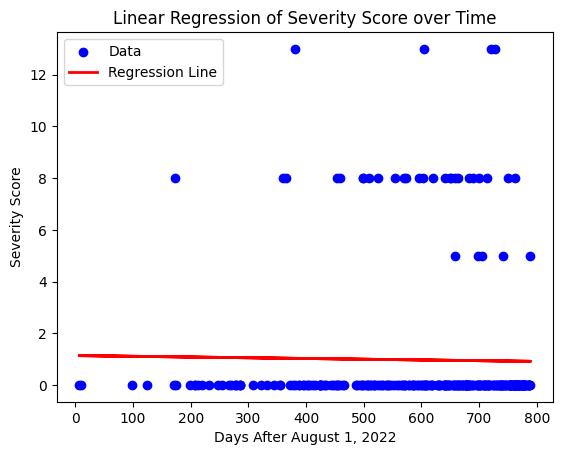

In [24]:

# Plot the results
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, model.predict(X), color='red', linewidth=2, label='Regression Line')
plt.xlabel("Days After August 1, 2022")
plt.ylabel("Severity Score")
plt.title("Linear Regression of Severity Score over Time")
plt.legend()
plt.show()

In [25]:
# Load data for next regression
accidents_df = pd.read_csv("accident_data.csv")
trips_df = pd.read_csv("data/trips.csv")

In [26]:
# Count accidents per month
accidents_per_month = (
    accidents_df
    .groupby("Year Month")  # group by the YYYYMM column
    .size()                 # count how many rows in each group
    .reset_index(name="Accident_Count")
)   


In [27]:

# Count trips per month
trips_df["Weekly Trips"] = trips_df["Weekly Trips"] * 4.3452381
trips_per_month = (
    trips_df
    .groupby("Year Month")      # group by the YYYYMM column
    ["Weekly Trips"]
    .sum()                      # sum up weekly trips for each month
    .reset_index(name="Monthly_Trips")
)

In [28]:

# Merge the two dataframes
merged = pd.merge(accidents_per_month, 
                  trips_per_month, 
                  on="Year Month", 
                  how="outer")  # outer merge in case some months have 0 accidents

In [29]:


# Filter data between August 2023 and September 2024
min_yyyymm = 202309
max_yyyymm = 202409

merged["Year Month"] = merged["Year Month"].astype(int)
merged = merged[(merged["Year Month"] >= min_yyyymm) & 
                (merged["Year Month"] <= max_yyyymm)]

In [30]:

# Remove rows with missing data
merged["Accident_Count"] = merged["Accident_Count"].fillna(0)
merged["Monthly_Trips"] = merged["Monthly_Trips"].fillna(0)

In [31]:

# Compute the probability of an accident (month-by-month)
merged["Probability_of_Accident"] = merged.apply(
    lambda row: row["Accident_Count"] / row["Monthly_Trips"] 
    if row["Monthly_Trips"] > 0 
    else 0, 
    axis=1
)

In [32]:

# Add column for months after August 2023 (reference date) and sort
def months_after_aug2023(yyyymm):
    """
    Given an integer or string of the form YYYYMM, 
    return how many months after 2023-08 it is.
    For example:
        202308 -> 0
        202309 -> 1
        202408 -> 12
        202412 -> 16
    """
    # Convert to string in case it's read as integer
    yyyymm_str = str(yyyymm)
    year = int(yyyymm_str[:4])
    month = int(yyyymm_str[4:])
    
    # Calculate months relative to August 2023 → year=2023, month=8
    return (year - 2023) * 12 + (month - 8)

merged["Months_After_Aug2023"] = merged["Year Month"].apply(months_after_aug2023)
merged = merged.sort_values("Months_After_Aug2023")

In [33]:

# Reshape the data for use with scikit-learn
X = merged["Months_After_Aug2023"].values.reshape(-1, 1)  # scikit-learn wants a 2D array
y = merged["Probability_of_Accident"].values

In [34]:

# Fit a linear regression model
model = LinearRegression()
model.fit(X, y)

# Print summary of results
predictions = model.predict(X)
slope = model.coef_[0]
intercept = model.intercept_
r2 = r2_score(y, predictions)
results_df = merged.copy()
results_df["Predicted_Probability"] = predictions
print("Linear Regression Results:")
print(f"  Intercept (probability at month=0 → August 2023): {intercept:.8f}")
print(f"  Slope (change in probability per 1-month increase): {slope:.8f}")
print(f"  R-squared: {r2:.8f}")
print("\nSummary of each month:")
print(results_df[[
    "Year Month", 
    "Months_After_Aug2023", 
    "Accident_Count", 
    "Monthly_Trips", 
    "Probability_of_Accident", 
    "Predicted_Probability"
]])

Linear Regression Results:
  Intercept (probability at month=0 → August 2023): 0.00022701
  Slope (change in probability per 1-month increase): -0.00000778
  R-squared: 0.26475982

Summary of each month:
    Year Month  Months_After_Aug2023  Accident_Count  Monthly_Trips  \
15      202309                     1            11.0   39007.347264   
16      202310                     2            12.0   55434.865638   
17      202311                     3             5.0   57689.263938   
18      202312                     4            16.0   71223.078052   
19      202401                     5            14.0   75784.596859   
20      202402                     6            11.0   77857.227113   
21      202403                     7            20.0   82271.196321   
22      202404                     8            11.0   93272.708436   
23      202405                     9            30.0  140915.510917   
24      202406                    10            30.0  191462.778002   
25      202407 

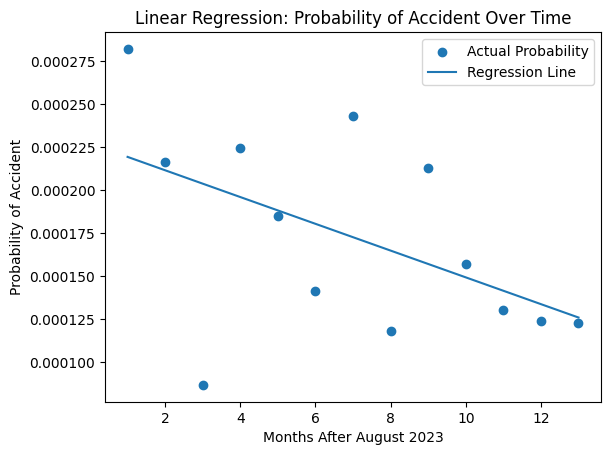

In [35]:
# Plot
plt.scatter(X, y, label='Actual Probability')
plt.plot(X, predictions, label='Regression Line')

plt.xlabel('Months After August 2023')
plt.ylabel('Probability of Accident')
plt.title('Linear Regression: Probability of Accident Over Time')
plt.legend()
plt.show()